## CLASSIFICATION: UNCLASSIFIED

## Autoencoders

We build an autoencoder for image data that takes images of size 28x28 as
input, encodes each image down to size 6x6, then reconstruct the images.

One usage for autoencoders is for dimension reduction, where an image can be 
viewevd as a 784-dimension feature vector, which we map down to 36-dimensions.

The images we use are the MNIST digits (0 to 9)



In [1]:
from __future__ import print_function

import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)


## Read the data

There are 60,000 images in the training set, 10,000 in the test set.


In [2]:
## load the pickle file with the data already divided as train/test sets

import get_data
get_data.get_file("mnist.pkl", "../data/")
with open('./data/mnist.pkl','rb') as infile:
    U = pickle._Unpickler(infile)
    U.encoding = 'latin1'
    (x_train,y_train), (x_test,y_test) = U.load()

## format
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


## Autoencoders

We use Keras to build the following autoencoder:
    
* Dense layer: map the (flatten) 784-dim images down to 128-dim
* Dense layer: down th 36-dim (this is the encoded image)
* Dense layer: up to 128-dim
* Dense layer: up to 784-dim (the is the reconstructed, flatten image)


In [3]:
## simple autoencoder
from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 36
mid_dim = 128
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(Dense(mid_dim, activation='relu')(input_img))
decoded = Dense(784, activation='sigmoid')(Dense(mid_dim,activation='relu')(encoded))
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 36)                4644      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4736      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 210,996.0
Trainable params: 210,996.0
Non-trainable params: 0.0
_________________________________________________________________


## Fit the models

* autoencoder: the full process, reconstructing the images
* encoder: the first half only (from 784 to 36 dimensions)

In [4]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, 
                validation_data=(x_test,x_test),verbose=0)
encoder = Model(inputs=input_img, outputs=encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 36)                4644      
Total params: 105,124.0
Trainable params: 105,124.0
Non-trainable params: 0.0
_________________________________________________________________


## Apply models to test data

In [5]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)


## Visualization

We pick a random sample of 10 test images and we plot respectively:
    
* the 28x28 image (row 1)
* the 36-dim encoded version (row 2 - represented as a 6x6 "image")
* the 28x28 reconstructed image (row 3)

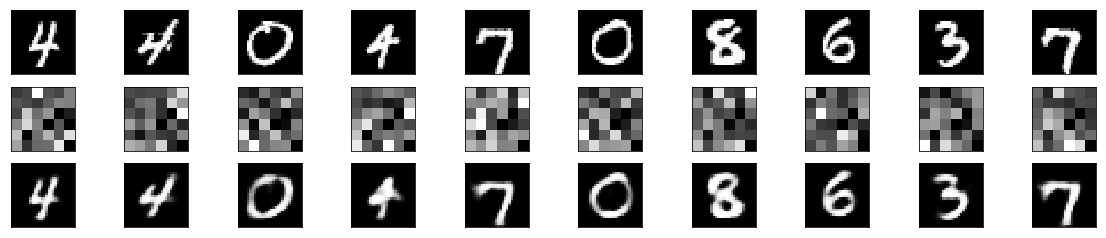

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

n=10
idx = random.sample(range(len(x_test)),n)
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ## 16d encoding
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(encoded_imgs[i].reshape(6,6))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ## reconstructed
    ax = plt.subplot(3, n, i+1+(2*n))
    plt.imshow(decoded_imgs[idx[i]].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## T-SNE on the encoded (test) images

The encoded images are 36-dim vectors. We use the T-SNE mapping to map
a subset of those images down to 2-dim for visualisation. We plot those below,
using the actual, true digit value.

Some digits seem to appear in 2 or moer "clusters" which likely account for various
writing styles. We also notice that some distinct digits are quite close, like some 4's and 9's.


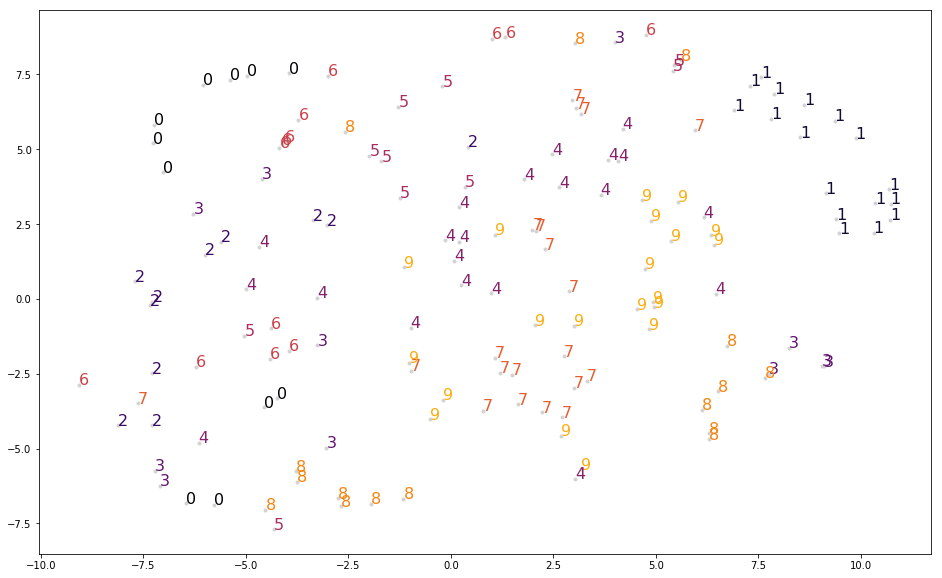

In [7]:
from sklearn.manifold import TSNE
from matplotlib import cm
import pandas as pd

n = 150
idx = random.sample(range(len(encoded_imgs)),n)

## t-SNE 
cmap = cm.get_cmap("inferno",12)
tsne = TSNE(learning_rate=100, perplexity=30, n_iter_without_progress=100)
df = tsne.fit_transform(encoded_imgs[idx])
vizdata = pd.DataFrame(df, columns=['x', 'y'])
vizdata['digit'] = y_test[idx]

# Plot and annotate with true digit
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(vizdata.x, vizdata.y, marker='.', c='lightgray')
for i in range(n):
    ax.annotate(vizdata.digit[i], (vizdata.x[i], vizdata.y[i]), color=cmap.colors[vizdata.digit[i]], fontsize=16)
    

## Classification 

We build and test a simple random forest classification model on the 36-dim
encoded digits. 

Applying this model to the test data shows accuracy around 95%.


In [8]:
## Random Forest - here with 200 trees
## Training on low-dim image representation
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
encoded_train = encoder.predict(x_train) ## encoded training data
rfc.fit(encoded_train, y_train)

from sklearn import metrics
## accuracy score: proportion correctly labelled
print('accuracy =',rfc.score(encoded_imgs, y_test))
## confusion matrix
pred = rfc.predict(encoded_imgs)
print('Confusion matrix:\n',metrics.confusion_matrix(y_test, pred),'\n')


accuracy = 0.9507
Confusion matrix:
 [[ 965    0    0    0    0    4    6    2    3    0]
 [   0 1117    4    3    0    2    6    0    3    0]
 [  16    0  975    6    3    4    2    8   17    1]
 [   3    0    9  949    2   14    0   10   19    4]
 [   0    0    7    0  935    1    3    0    3   33]
 [   4    1    4   24    4  836    8    2    9    0]
 [  12    3    3    1    4    7  926    0    2    0]
 [   1    4   20    1   12    1    1  962    2   24]
 [   5    0    5   14   10   14    4    8  909    5]
 [   7    5    6   13   22    3    1   15    4  933]] 



## Visualizing errors with kNN

We build a $k$ nearest neighbours classifier with $k=1$ in order to see some examples
which are likely difficult to classifiy. In gthe cells below:

* we build the kNN classifier 
* we identify the test images for which the nearest neighbous is of a different class, and
* we plot a random subset of those, along with the nearest neighbour from the training set.


In [9]:
## kNN
from sklearn.neighbors import KNeighborsClassifier
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(encoded_train,y_train)
N = kNN.predict(encoded_imgs)

## misclassified points (different class nearest neighbour)
misClass = [i for i in range(10000) if N[i] != y_test[i]]
misClassNeighbour = kNN.kneighbors(encoded_imgs, 1)[1]


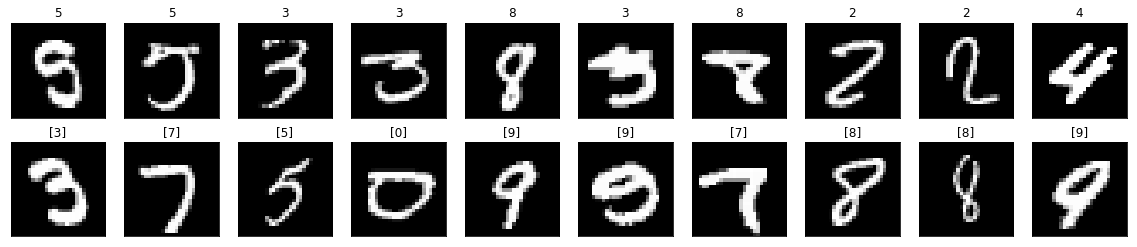

In [10]:
## Plot some test images with NN of a different class
n=10
idx = random.sample(range(len(misClass)),n)
plt.figure(figsize=(20,4))

for i in range(n):
    ## digit
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[misClass[idx[i]]].reshape(28,28))
    plt.title(y_test[misClass[idx[i]]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ## nearest neighbour
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(x_train[misClassNeighbour[misClass[idx[i]]]].reshape(28,28))
    plt.title(y_train[misClassNeighbour[misClass[idx[i]]]])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
